In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [5]:
rcParams['figure.figsize'] = 16,4

In [6]:
dot_data_1 = pd.read_csv(path + '20190103_1.csv', parse_dates=[1])
dot_data_2 = pd.read_csv(path + '20190103_2.csv', parse_dates = [1])

In [7]:
dot_data = pd.concat([dot_data_1,dot_data_2], ignore_index = True)
dot_data['order_date'] = pd.to_datetime(dot_data['order_date'])
data = dot_data.copy()
data.head()

,Unnamed: 0,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [8]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [9]:
len(data['dot'].unique())

6948

In [10]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,Unnamed: 0,dot,order_date,order_num
order_date,,,,
2017-05-23,0,13825092291,2017-05-23,1
2017-06-06,1,15102680258,2017-06-06,1
2017-06-09,2,ERP客户系统组,2017-06-09,1
2017-04-13,3,IT采购组,2017-04-13,8
2017-05-03,4,IT采购组,2017-05-03,4


In [11]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,Unnamed: 0,dot,order_date,order_num
order_date,,,,
2017-12-01,143767,坂田上雪点部,2017-12-01,313
2017-12-01,721855,嘉定城区点部,2017-12-01,20
2017-12-01,526611,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,182541,无锡旺庄点部,2017-12-01,58
2017-12-01,150202,宝安机场分拨一区包车组,2017-12-01,2


In [12]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

338

### 数据分析

In [13]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()

,Unnamed: 0,dot,order_date,order_num
order_date,,,,
2017-12-01,143767,坂田上雪点部,2017-12-01,313
2017-12-01,558858,常熟董浜点部,2017-12-01,29
2017-12-01,191655,江宁保税区点部,2017-12-01,70
2017-12-01,110465,厦门前埔点部,2017-12-01,39
2017-12-01,235444,滨海沙城点部,2017-12-01,24


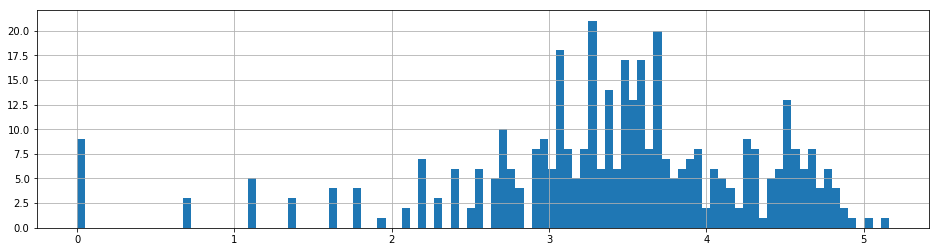

In [24]:
result_ts = result_data.loc[result_data['dot'] == '江宁保税区点部', ['order_num']]
# result_ts = np.log(result_ts)
result_ts = result_ts['order_num'].resample('D').sum()
# result_ts.plot(figsize = (6,4), color = 'r', linewidth=1, xlim = ['2018-08-01','2018-09-01'])
# result_ts.hist(bins=100)
np.log1p(result_ts).hist(bins=100)

## 数据处理

In [12]:
# dot_preprocessing = pd.DataFrame()
# for i, dot in enumerate(useful_dot_name['dot']):
#     one_dot = data.loc[data['dot'] == dot]
#     ts = pd.date_range(one_dot.order_date.min(), one_dot.order_date.max())
#     df_ts = pd.DataFrame(ts, columns = ['order_date'])
#     df_ts['dot'] = dot
#     df_ts['dot_id'] = i+1
#     merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res.fillna(0, inplace = True)
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
#     if len(merge_res) >= 390:
#         dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data.loc[data['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i+1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [13]:
dot_prep = dot_preprocessing[['dot', 'dot_id', 'order_date', 'order_num']]
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,dot,dot_id,order_date,order_num
0,东丽机场点部,1,2017-12-01,40.0
63806,新区狮山点部,161,2017-12-01,42.0
101293,相城黄埭点部,255,2017-12-01,32.0
63407,扬州郭集点部,160,2017-12-01,14.0
101692,相城黄桥点部,256,2017-12-01,32.0


### 时间

In [14]:
dot_prep_1 = dot_prep.copy()

In [15]:
dot_prep_1['year'] = dot_prep_1.order_date.dt.year
dot_prep_1['month'] = dot_prep_1.order_date.dt.month
dot_prep_1['day'] = dot_prep_1.order_date.dt.day
dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
dot_prep_1.head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48
63806,新区狮山点部,161,2017-12-01,42.0,2017,12,1,4,335,48
101293,相城黄埭点部,255,2017-12-01,32.0,2017,12,1,4,335,48
63407,扬州郭集点部,160,2017-12-01,14.0,2017,12,1,4,335,48
101692,相城黄桥点部,256,2017-12-01,32.0,2017,12,1,4,335,48


### 增加周日特征

In [16]:
weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
weekofsun

DatetimeIndex(['2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24',
               '2017-12-31', '2018-01-07', '2018-01-14', '2018-01-21',
               '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01', '2018-04-08', '2018-04-15',
               '2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13',
               '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10',
               '2018-06-17', '2018-06-24', '2018-07-01', '2018-07-08',
               '2018-07-15', '2018-07-22', '2018-07-29', '2018-08-05',
               '2018-08-12', '2018-08-19', '2018-08-26', '2018-09-02',
               '2018-09-09', '2018-09-16', '2018-09-23', '2018-09-30',
               '2018-10-07', '2018-10-14', '2018-10-21', '2018-10-28',
               '2018-11-04', '2018-11-11', '2018-11-18', '2018-11-25',
               '2018-12-02', '2018-12-09', '2018-12-16', '2018-12-23',
      

In [17]:
dot_prep_1['weekofsun'] = 0
dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1

### 季节

In [24]:
dot_prep_1['season'] = 1
dot_prep_1.loc[dot_prep_1['month'].isin([1,2,3]), ['season']] = 1
dot_prep_1.loc[dot_prep_1['month'].isin([4,5,6]), ['season']] = 2
dot_prep_1.loc[dot_prep_1['month'].isin([7,8,9]), ['season']] = 3
dot_prep_1.loc[dot_prep_1['month'].isin([10,11,12]), ['season']] = 4
dot_prep_1.head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,season
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48,0,4
63806,新区狮山点部,161,2017-12-01,42.0,2017,12,1,4,335,48,0,4
101293,相城黄埭点部,255,2017-12-01,32.0,2017,12,1,4,335,48,0,4
63407,扬州郭集点部,160,2017-12-01,14.0,2017,12,1,4,335,48,0,4
101692,相城黄桥点部,256,2017-12-01,32.0,2017,12,1,4,335,48,0,4


### 节假日

In [18]:
dot_prep_1['holidays'] = 0
dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])),
            ['holidays']] = 1
dot_prep_1.head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48,0,0
63806,新区狮山点部,161,2017-12-01,42.0,2017,12,1,4,335,48,0,0
101293,相城黄埭点部,255,2017-12-01,32.0,2017,12,1,4,335,48,0,0
63407,扬州郭集点部,160,2017-12-01,14.0,2017,12,1,4,335,48,0,0
101692,相城黄桥点部,256,2017-12-01,32.0,2017,12,1,4,335,48,0,0


## lagging

In [19]:
dot_prep_ts = dot_prep.copy()
dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
dot_prep_ts[dot_prep_ts['dot_id'] == 338].tail()

,dot,dot_id,order_date,order_num
order_date,,,,
2018-12-30,龙岗龙东点部,338,2018-12-30,49.0
2018-12-31,龙岗龙东点部,338,2018-12-31,29.0
2019-01-01,龙岗龙东点部,338,2019-01-01,14.0
2019-01-02,龙岗龙东点部,338,2019-01-02,78.0
2019-01-03,龙岗龙东点部,338,2019-01-03,4.0


In [45]:
dot_prep_2 = pd.DataFrame()
for dot in useful_dot_name['dot']:
    dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
    lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
    lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
    lagging['dot'] = dot
    lagging['order_date'] = dot_ts.index
#     lagging.dropna(axis = 0, inplace = True)
    dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
dot_prep_2.head(10)

,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,dot,order_date
order_date,,,,,,,,,
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-01
2017-12-02,40.0,NaN,NaN,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-02
2017-12-03,36.0,40.0,NaN,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-03
2017-12-04,14.0,36.0,40.0,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-04
2017-12-05,64.0,14.0,36.0,40.0,NaN,NaN,NaN,东丽机场点部,2017-12-05
2017-12-06,48.0,64.0,14.0,36.0,40.0,NaN,NaN,东丽机场点部,2017-12-06
2017-12-07,53.0,48.0,64.0,14.0,36.0,40.0,NaN,东丽机场点部,2017-12-07
2017-12-08,50.0,53.0,48.0,64.0,14.0,36.0,40.0,东丽机场点部,2017-12-08
2017-12-09,67.0,50.0,53.0,48.0,64.0,14.0,36.0,东丽机场点部,2017-12-09


In [46]:
dot_prep_2.reset_index(drop = True, inplace = True)
dot_prep_2.tail()

,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,dot,order_date
134785,78.0,82.0,81.0,82.0,80.0,85.0,25.0,龙岗龙东点部,2018-12-30
134786,49.0,78.0,82.0,81.0,82.0,80.0,85.0,龙岗龙东点部,2018-12-31
134787,29.0,49.0,78.0,82.0,81.0,82.0,80.0,龙岗龙东点部,2019-01-01
134788,14.0,29.0,49.0,78.0,82.0,81.0,82.0,龙岗龙东点部,2019-01-02
134789,78.0,14.0,29.0,49.0,78.0,82.0,81.0,龙岗龙东点部,2019-01-03


In [47]:
dot_prep_1.head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48,0,0
63806,新区狮山点部,161,2017-12-01,42.0,2017,12,1,4,335,48,0,0
101293,相城黄埭点部,255,2017-12-01,32.0,2017,12,1,4,335,48,0,0
63407,扬州郭集点部,160,2017-12-01,14.0,2017,12,1,4,335,48,0,0
101692,相城黄桥点部,256,2017-12-01,32.0,2017,12,1,4,335,48,0,0


In [48]:
dot_prep_2.head()

,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,dot,order_date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-01
1,40.0,NaN,NaN,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-02
2,36.0,40.0,NaN,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-03
3,14.0,36.0,40.0,NaN,NaN,NaN,NaN,东丽机场点部,2017-12-04
4,64.0,14.0,36.0,40.0,NaN,NaN,NaN,东丽机场点部,2017-12-05


In [49]:
a = pd.merge(dot_prep_1, dot_prep_2, how = 'left', on = ['dot', 'order_date'])
a[a['dot_id'] == 1].head(10)

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,东丽机场点部,1,2017-12-02,36.0,2017,12,2,5,336,48,0,0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
1012,东丽机场点部,1,2017-12-03,14.0,2017,12,3,6,337,48,1,0,36.0,40.0,NaN,NaN,NaN,NaN,NaN
1326,东丽机场点部,1,2017-12-04,64.0,2017,12,4,0,338,49,0,0,14.0,36.0,40.0,NaN,NaN,NaN,NaN
1462,东丽机场点部,1,2017-12-05,48.0,2017,12,5,1,339,49,0,0,64.0,14.0,36.0,40.0,NaN,NaN,NaN
1865,东丽机场点部,1,2017-12-06,53.0,2017,12,6,2,340,49,0,0,48.0,64.0,14.0,36.0,40.0,NaN,NaN
2333,东丽机场点部,1,2017-12-07,50.0,2017,12,7,3,341,49,0,0,53.0,48.0,64.0,14.0,36.0,40.0,NaN
2386,东丽机场点部,1,2017-12-08,67.0,2017,12,8,4,342,49,0,0,50.0,53.0,48.0,64.0,14.0,36.0,40.0
3017,东丽机场点部,1,2017-12-09,47.0,2017,12,9,5,343,49,0,0,67.0,50.0,53.0,48.0,64.0,14.0,36.0
3244,东丽机场点部,1,2017-12-10,29.0,2017,12,10,6,344,49,1,0,47.0,67.0,50.0,53.0,48.0,64.0,14.0


## rolling

In [23]:
dot_prep_ts.head()

,dot,dot_id,order_date,order_num
order_date,,,,
2017-12-01,东丽机场点部,1,2017-12-01,40.0
2017-12-01,新区狮山点部,161,2017-12-01,42.0
2017-12-01,相城黄埭点部,255,2017-12-01,32.0
2017-12-01,扬州郭集点部,160,2017-12-01,14.0
2017-12-01,相城黄桥点部,256,2017-12-01,32.0


In [24]:
dot_prep_3 = pd.DataFrame()
for dot in useful_dot_name['dot']:
    dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
    rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
    rolling.columns = ['rolling3', 'rolling7']
    rolling['dot'] = dot
    rolling['order_date'] = dot_ts.index
    rolling.dropna(axis = 0, inplace = True)
    dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
dot_prep_3.head()

,rolling3,rolling7,dot,order_date
order_date,,,,
2017-12-07,50.333333,43.571429,东丽机场点部,2017-12-07
2017-12-08,56.666667,47.428571,东丽机场点部,2017-12-08
2017-12-09,54.666667,49.000000,东丽机场点部,2017-12-09
2017-12-10,47.666667,51.142857,东丽机场点部,2017-12-10
2017-12-11,42.666667,49.428571,东丽机场点部,2017-12-11


In [25]:
dot_prep_3.reset_index(drop = True, inplace = True)
dot_prep_3.head()

,rolling3,rolling7,dot,order_date
0,50.333333,43.571429,东丽机场点部,2017-12-07
1,56.666667,47.428571,东丽机场点部,2017-12-08
2,54.666667,49.000000,东丽机场点部,2017-12-09
3,47.666667,51.142857,东丽机场点部,2017-12-10
4,42.666667,49.428571,东丽机场点部,2017-12-11


## 统计特征

In [26]:
dot_prep_4 = dot_prep_1.copy()
dot_prep_4.head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48,0,0
63806,新区狮山点部,161,2017-12-01,42.0,2017,12,1,4,335,48,0,0
101293,相城黄埭点部,255,2017-12-01,32.0,2017,12,1,4,335,48,0,0
63407,扬州郭集点部,160,2017-12-01,14.0,2017,12,1,4,335,48,0,0
101692,相城黄桥点部,256,2017-12-01,32.0,2017,12,1,4,335,48,0,0


In [28]:
dot_prep_dayofweek = dot_prep_4.groupby(['dot_id', 'dayofweek'])['order_num'].agg([('mean', np.mean), ('median', np.median), ('min', np.min), ('max', np.max), ('std', np.std)]).reset_index()
dot_prep_day = dot_prep_4.groupby(['dot_id', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 134790 entries, 0 to 134789
Data columns (total 22 columns):
dot           134790 non-null object
dot_id        134790 non-null int64
order_date    134790 non-null datetime64[ns]
order_num     134790 non-null float64
year          134790 non-null int64
month         134790 non-null int64
day           134790 non-null int64
dayofweek     134790 non-null int64
dayofyear     134790 non-null int64
weekofyear    134790 non-null int64
weekofsun     134790 non-null int64
holidays      134790 non-null int64
mean          134790 non-null float64
median        134790 non-null float64
min           134790 non-null float64
max           134790 non-null float64
std           134790 non-null float64
day_mean      134790 non-null float64
day_median    134790 non-null float64
day_min       134790 non-null float64
day_max       134790 non-null float64
day_std       134790 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(9), object(1)
memor

In [67]:
pd.merge(dot_prep_4, dot_prep_tmp, on = ['dot_id', 'dayofweek'], how = 'left').head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays,mean,median,min,max,std
0,东丽机场点部,1,2017-12-01,40.0,2017,12,1,4,335,48,0,0,57.543860,56.0,2.0,114.0,17.160035
1,新区狮山点部,161,2017-12-01,42.0,2017,12,1,4,335,48,0,0,39.245614,38.0,0.0,73.0,15.828637
2,相城黄埭点部,255,2017-12-01,32.0,2017,12,1,4,335,48,0,0,46.403509,40.0,0.0,315.0,40.143430
3,扬州郭集点部,160,2017-12-01,14.0,2017,12,1,4,335,48,0,0,10.315789,9.0,0.0,27.0,6.074413
4,相城黄桥点部,256,2017-12-01,32.0,2017,12,1,4,335,48,0,0,36.000000,36.0,2.0,59.0,9.728456


## merge

In [129]:
dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
dot_prep_result.head()

,dot,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,...,holidays,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling7
0,光明楼村点部,15,2017-12-08,35.0,2017,12,8,4,342,49,...,0,42.0,33.0,33.0,24.0,1.0,24.0,47.0,36.666667,27.428571
230,罗湖田贝点部,279,2017-12-08,267.0,2017,12,8,4,342,49,...,0,226.0,221.0,218.0,205.0,112.0,169.0,180.0,238.000000,202.571429
229,扬州仪征点部,158,2017-12-08,20.0,2017,12,8,4,342,49,...,0,16.0,19.0,21.0,14.0,13.0,12.0,14.0,18.333333,16.428571
228,吴江兴瑞点部,59,2017-12-08,32.0,2017,12,8,4,342,49,...,0,33.0,32.0,32.0,32.0,4.0,19.0,45.0,32.333333,26.285714
227,慈溪逍林点部,157,2017-12-08,20.0,2017,12,8,4,342,49,...,0,27.0,29.0,22.0,28.0,18.0,25.0,43.0,25.333333,24.142857


In [117]:
dot_prep_result.columns

Index(['dot', 'dot_id', 'order_date', 'order_num', 'year', 'month', 'day',
       'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'season',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling7'],
      dtype='object')

## train_predict

In [131]:
dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)

In [133]:
dot_prep_result.head()

,dot_id,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,season,holidays,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling7
0,15,35.0,2017,12,8,4,342,49,0,4,0,42.0,33.0,33.0,24.0,1.0,24.0,47.0,36.666667,27.428571
230,279,267.0,2017,12,8,4,342,49,0,4,0,226.0,221.0,218.0,205.0,112.0,169.0,180.0,238.000000,202.571429
229,158,20.0,2017,12,8,4,342,49,0,4,0,16.0,19.0,21.0,14.0,13.0,12.0,14.0,18.333333,16.428571
228,59,32.0,2017,12,8,4,342,49,0,4,0,33.0,32.0,32.0,32.0,4.0,19.0,45.0,32.333333,26.285714
227,157,20.0,2017,12,8,4,342,49,0,4,0,27.0,29.0,22.0,28.0,18.0,25.0,43.0,25.333333,24.142857


In [134]:
dot_train = dot_prep_result[: -(30 * 338)]
dot_test = dot_prep_result[-(30 * 338) :]   # 每个点部留一个月数据做测试

In [135]:
len(dot_test[dot_test['dot_id'] == 6])

31

In [136]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [142]:
dot_xtest.head()

,dot_id,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,season,holidays,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling7
122151,56,2018,12,4,1,338,49,0,4,0,46.0,25.0,22.0,41.0,45.0,39.0,52.0,40.333333,38.285714
122150,89,2018,12,4,1,338,49,0,4,0,67.0,44.0,54.0,109.0,97.0,87.0,103.0,61.666667,76.000000
122149,70,2018,12,4,1,338,49,0,4,0,109.0,32.0,67.0,158.0,96.0,76.0,101.0,90.666667,95.571429
122148,95,2018,12,4,1,338,49,0,4,0,191.0,152.0,193.0,293.0,411.0,366.0,458.0,185.333333,259.857143
122147,269,2018,12,4,1,338,49,0,4,0,27.0,3.0,12.0,34.0,26.0,10.0,22.0,18.666667,19.714286


In [137]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [138]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [139]:
from xgboost import plot_importance
def xgboost_model(x_train, y_train, x_test, y_test, path):
    params = {
        "learning_rate": 0.01,                   # [0,1]， 默认0.3
        "n_estimators": 3300,
        "max_depth": 5,                         # [0,∞]， 默认6
        "min_child_weight": 3,                  # [0,∞]， 默认1
        "gamma": 0.5,                             # [0,∞]， 默认0
        "subsample": 0.9,                       # (0,1]， 默认1
        "colsample_bytree": 0.8,                # (0,1]， 默认1
        "silent": 1,                            # 默认0，输出信息
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train, y_train)
    
    for column, importance in zip(x_train.columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")

    y_pre = gbm.predict(x_test)
    result = pd.DataFrame({'dot_id' : x_test['dot_id'], 'y_test' : y_test, 'y_pre' : y_pre})
    result['RMSE'] = RMSE(y_test, y_pre)
    result['MAE'] = MAE(y_test, y_pre)
    print(MAE(y_test, y_pre), RMSE(y_test, y_pre))
    
    col_1 = ['y_test','y_pre']
    L = np.random.randint( low = 1,high = 338, size = 3 )
    for i in L:
        s1 = pd.DataFrame(result[result['dot_id'] == i],columns = col_1)
        s1.plot(title = 'dot_id {}'.format(i), figsize = (12,4))

    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)

dot_id 	 0.008490483
year 	 0.00034922297
month 	 0.0074209883
day 	 0.021280775
dayofweek 	 0.0454099
dayofyear 	 0.019436441
weekofyear 	 0.0022917758
weekofsun 	 0.0044744196
season 	 3.2739656e-05
holidays 	 0.013772481
lagging1 	 0.19779116
lagging2 	 0.1870853
lagging3 	 0.03472586
lagging4 	 0.030786188
lagging5 	 0.031320937
lagging6 	 0.033481754
lagging7 	 0.0535839
rolling3 	 0.24543828
rolling7 	 0.06282739
6.046566082687067 24.94162905848046


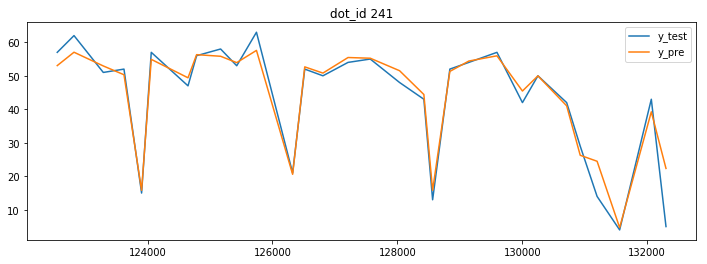

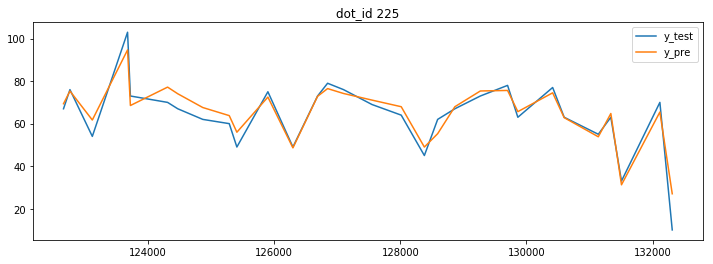

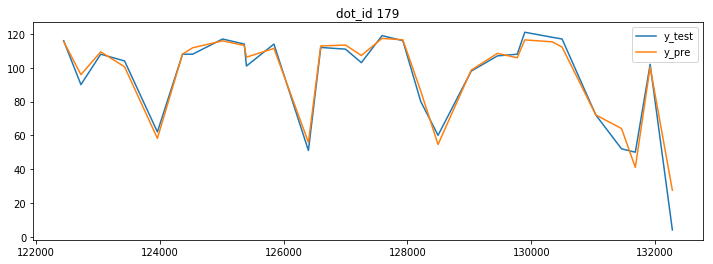

In [141]:
xgboost_model(dot_xtrain, dot_ytrain, dot_xtest, dot_ytest, path)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 380, ['dot']]
useful_dot_name.head()

,dot
30,上虞上浦点部
31,上虞东关点部
57,东丽中心庄点部
61,东丽塘沽点部
62,东丽宁河点部


In [9]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,常熟董浜点部,2017-12-01,29
2017-12-01,江宁保税区点部,2017-12-01,70
2017-12-01,盛泽黎星点部,2017-12-01,39


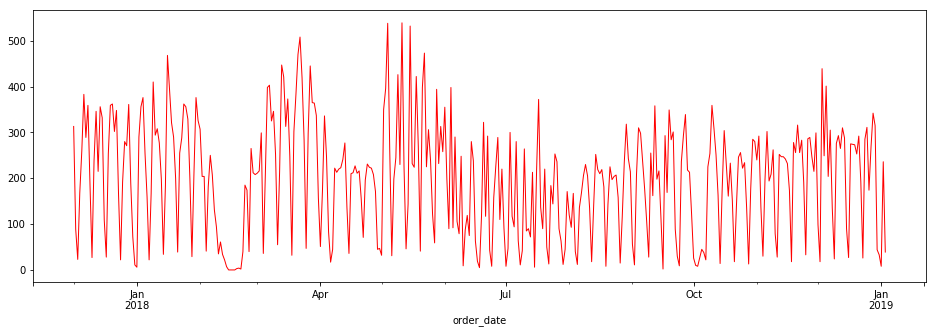

In [10]:
result_ts = result_data.loc[result_data['dot'] == '坂田上雪点部', ['order_num']]  
# result_ts = np.log1p(result_ts)
result_ts = result_ts['order_num'].resample('D').sum()
result_ts.plot(figsize = (16,5), color = 'r', linewidth=1)

In [ ]:
result_ts_train = result_ts[ : -10]
result_ts_test = result_ts[-10 : ]